### Supermarket data science case study - Exploring first data


### Importing packages

In [75]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import altair as alt
import vegafusion as vf
import sklearn
import vega_datasets
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np


### Functions

In [76]:
def f_concat(l_input):

    # Initialize.
    dummy = ""
    n_len = len(l_input)

    if n_len == 1:
        return l_input[0]

    # Loop through text elements.
    for i in range(n_len - 1):
        dummy = dummy + l_input[i] + ", "

    # Append last element.
    dummy = dummy + "and " + l_input[n_len - 1]

    # Return result.
    return dummy

In [77]:
def f_describe(df_input, n_top=10):

    print("First " + str(n_top) + " rows in de data:")
    display(df_input.head(n_top))

    df_numeric = df_input.select_dtypes(
        include=[
            "uint8",
            "uint16",
            "uint32",
            "uint64",
            "int8",
            "int16",
            "int32",
            "int64",
            "float16",
            "float32",
            "float64",
        ]
    )

    if len(df_numeric.columns):
        print("Numerical data:")
        display(df_numeric.describe())

    df_textual = df_input.select_dtypes(include=["category", "object", "bool"])

    if len(df_textual.columns):
        print("Textual data:")
        display(df_textual.describe())

    v_na = [
        col
        + " ("
        + str(df[col].isna().sum())
        + ", "
        + str(round(100 * df[col].isna().sum() / df.shape[0], 1))
        + "%)"
        for col in df.columns
        if df[col].isna().sum() > 0
    ]

    if len(v_na) > 0:
        print("Features and their number of missing values:")
        display(f_concat(v_na))

### Downcast and transform data
Update formatting of features to optimize memory and standardize column names.

In [78]:
def standardize_column_names(s):
    return s.replace(" ", "")


def optimize_memory(df):
    # Change: Objects to Categorical.                                               #WHEN needed to transform Objects to Categorical?
    # object_cols = df.select_dtypes(include="object").columns
    # if not object_cols.empty:
    #     print("Change: Objects to Categorical")
    #     df[object_cols] = df[object_cols].astype("category")

    # Change: Convert integers to smallest unsigned integer and floats to smallest.
    for old, new in [("integer", "unsigned"), ("float", "float")]:
        print("Change: " + old + " --> " + new)
        for col in df.select_dtypes(include=old).columns:
            df[col] = pd.to_numeric(df[col], downcast=new)

    return df


def month_year_to_int(df, i):
    # Change: Month and Year to integer
    if i == 0:
        print("Change: Month and Year to integer")
        df = df.astype({"month": int, "year": int})

    return df

### Transform date-related columns to datetime format.

In [79]:
# Convert datasets to time series
def transform_date_to_datetime(df, i):
    if i == 0:
        print("Change: Transformed 'year', 'month', 'day' columns to Datetime feature")
        df["date"] = pd.to_datetime(df[["year", "month", "day"]], unit="us")

       # print(
       #     "Change: Dropped 'year', 'month', 'day' columns and transformed to Datetime64[us] feature"
       # )
        #df.drop(columns=["day", "month", "year"], inplace=True)

    else:
        if "date" in df.columns:
            print("Change: Transformed 'date' column to Datetime Dtype")
            df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

    return df

### Import data from local PATH
Import data trough pipeline to downcast the data and transformations

In [80]:
def f_get_data(i=0):

    # Define path.
    c_path = "/Users/Georgi/Documents/EAISI/EASI_4B_Supermarket/Group4B/data/raw/"
    # Identify file.
    v_file = (
        "history-per-year",  # 0
        "history_aggregated",  # 1
        "holidays_events",  # 2
        "items",  # 3
        "oil",  # 4
        "stores",  # 5
        "transactions",
    )  # 6

    # Load data.
    df = (
        pd.read_parquet(c_path + v_file[i] + ".parquet")
        .rename(columns=standardize_column_names)
        .pipe(optimize_memory)
        .pipe(month_year_to_int, i)
        .pipe(transform_date_to_datetime, i)
    )

    # Return data.
    return df

### Importing data: Here I import the daily data. The data contains daily sales data excluding holidays

In [81]:
df_salesdata= f_get_data(0)
df_items =f_get_data(3)

Change: integer --> unsigned
Change: float --> float
Change: Month and Year to integer
Change: Transformed 'year', 'month', 'day' columns to Datetime feature
Change: integer --> unsigned
Change: float --> float


In [82]:
df_salesdata = df_salesdata.drop(columns=['year', 'day','onpromotion','month'])
df_salesitems = df_salesdata.groupby(['item_nbr','date']).agg({'unit_sales':'sum'}).reset_index()
df_salesitems = df_salesitems.merge(df_items, left_on='item_nbr', right_on='item_nbr', how='inner')
print(f' In df_salesandstoredata zitten nu {df_salesitems.shape[0]} rijen en {df_salesitems.shape[1]} kolommen')
print(df_salesitems.info())

 In df_salesandstoredata zitten nu 4655109 rijen en 6 kolommen
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655109 entries, 0 to 4655108
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   item_nbr    uint32        
 1   date        datetime64[ns]
 2   unit_sales  float32       
 3   family      object        
 4   class       uint16        
 5   perishable  uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 119.9+ MB
None


## Step 3.0- Filter out all stores that don't have all the datapoint or atleast mark them


In [83]:
# Count amount of values per item
se_itemdatecount = df_salesitems['item_nbr'].value_counts()
print(se_itemdatecount)

item_nbr
205387     1684
315463     1684
1047786    1684
214862     1684
315322     1684
           ... 
2123863       3
2122947       3
2122818       2
2011451       1
2015898       1
Name: count, Length: 4036, dtype: int64


In [84]:
# Create a date range from the start date to the end date of the sales data
start_date = pd.to_datetime('2013-01-02')
end_date = pd.to_datetime('2017-08-15')

# Create a date range variable from the start date to the end date of the sales data
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a dataframe from the date range
date_range = pd.DataFrame(date_range, columns=['date'])

print(f'The date_range dataframe starts at {date_range["date"].min()} and ends at {date_range["date"].max()}')

The date_range dataframe starts at 2013-01-02 00:00:00 and ends at 2017-08-15 00:00:00


In [85]:
# Let's try to make a dataframe that consists of all items that are missing data for a certain date
# Step 1 - Crossjoin items with the daterange
df_itemsanddates = df_items.merge(date_range, how='cross')

print(f' Now we onstructed a dataframe with all stores and all dates, it contains {df_itemsanddates.shape[0]} rows')
print(df_itemsanddates.head(5))

# Step 2 - Merge the salesdata with the storesanddates dataframe to have a dataframe consisting of all items and all dates with unit_sales
df_salesitems_reduced=df_salesitems[['item_nbr', 'date','unit_sales']]

df_salesanditemsdata_alldates = df_itemsanddates.merge(df_salesitems_reduced, on = ['item_nbr','date'], how='outer')



 Now we onstructed a dataframe with all stores and all dates, it contains 6916700 rows
   item_nbr     family  class  perishable       date
0     96995  GROCERY I   1093           0 2013-01-02
1     96995  GROCERY I   1093           0 2013-01-03
2     96995  GROCERY I   1093           0 2013-01-04
3     96995  GROCERY I   1093           0 2013-01-05
4     96995  GROCERY I   1093           0 2013-01-06


In [86]:
print(df_salesanditemsdata_alldates.head(5))

   item_nbr     family   class  perishable       date  unit_sales
0     96995  GROCERY I  1093.0         0.0 2013-01-02         NaN
1     96995  GROCERY I  1093.0         0.0 2013-01-03         NaN
2     96995  GROCERY I  1093.0         0.0 2013-01-04         NaN
3     96995  GROCERY I  1093.0         0.0 2013-01-05         NaN
4     96995  GROCERY I  1093.0         0.0 2013-01-06         1.0


In [90]:
# Replace NaN values in 'unit_sales' with 0 for aggregation
df_salesanditemsdata_alldates['unit_sales'] = df_salesanditemsdata_alldates['unit_sales'].fillna(0)

# Extract year and month from 'date'
df_salesanditemsdata_alldates['year_month'] = df_salesanditemsdata_alldates['date'].dt.to_period('M')

# Group by 'year_month' and 'class' and sum the 'unit_sales'
monthly_sales = df_salesanditemsdata_alldates.groupby(['year_month', 'family'])['unit_sales'].sum().reset_index()

# Filter out groups where the sum of 'unit_sales' is greater than 0
positive_sales = monthly_sales[monthly_sales['unit_sales'] > 0]

# Count the number of unique classes for each month
classes_per_month = positive_sales.groupby('year_month')['family'].nunique().reset_index()
classes_per_month.columns = ['month', 'num_classes']

print(classes_per_month)


      month  num_classes
0   2013-01           21
1   2013-02           21
2   2013-03           22
3   2013-04           22
4   2013-05           22
5   2013-06           22
6   2013-07           22
7   2013-08           22
8   2013-09           22
9   2013-10           22
10  2013-11           22
11  2013-12           22
12  2014-01           31
13  2014-02           22
14  2014-03           32
15  2014-04           22
16  2014-05           22
17  2014-06           22
18  2014-07           32
19  2014-08           22
20  2014-09           32
21  2014-10           32
22  2014-11           32
23  2014-12           32
24  2015-01           24
25  2015-02           24
26  2015-03           24
27  2015-04           25
28  2015-05           27
29  2015-06           32
30  2015-07           32
31  2015-08           32
32  2015-09           32
33  2015-10           32
34  2015-11           32
35  2015-12           32
36  2016-01           32
37  2016-02           32
38  2016-03           32


In [94]:






# Calculate total sales for the entire period
total_sales = df_salesanditemsdata_alldates['unit_sales'].sum()

# Initialize an empty list to store the results
results = []

# Loop through each unique month
for month in df_salesanditemsdata_alldates['year_month'].unique():
    # Filter the data for the current month
    monthly_data = df_salesanditemsdata_alldates[df_salesanditemsdata_alldates['year_month'] == month]
    
    # Identify items with positive sales in the current month
    positive_items = monthly_data[monthly_data['unit_sales'] > 0]['item_nbr'].unique()
    
    # Calculate total sales for these items for the entire period
    positive_sales_total = df_salesanditemsdata_alldates[df_salesanditemsdata_alldates['item_nbr'].isin(positive_items)]['unit_sales'].sum()
    
    # Calculate percentage of total sales
    percentage_sales = (positive_sales_total / total_sales) * 100
    
    # Store the result
    results.append({'month': month, 'num_classes': len(positive_items), 'percentage_of_total_sales': percentage_sales})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

results_df



,month,num_classes,percentage_of_total_sales
0,2013-01,1617,57.259178
1,2013-02,1633,57.639879
2,2013-03,1668,59.088683
3,2013-04,1671,59.432387
4,2013-05,1677,59.531826
5,2013-06,1710,60.899693
6,2013-07,1732,61.646146
7,2013-08,1754,62.549675
8,2013-09,1774,62.844878
9,2013-10,1791,63.106728


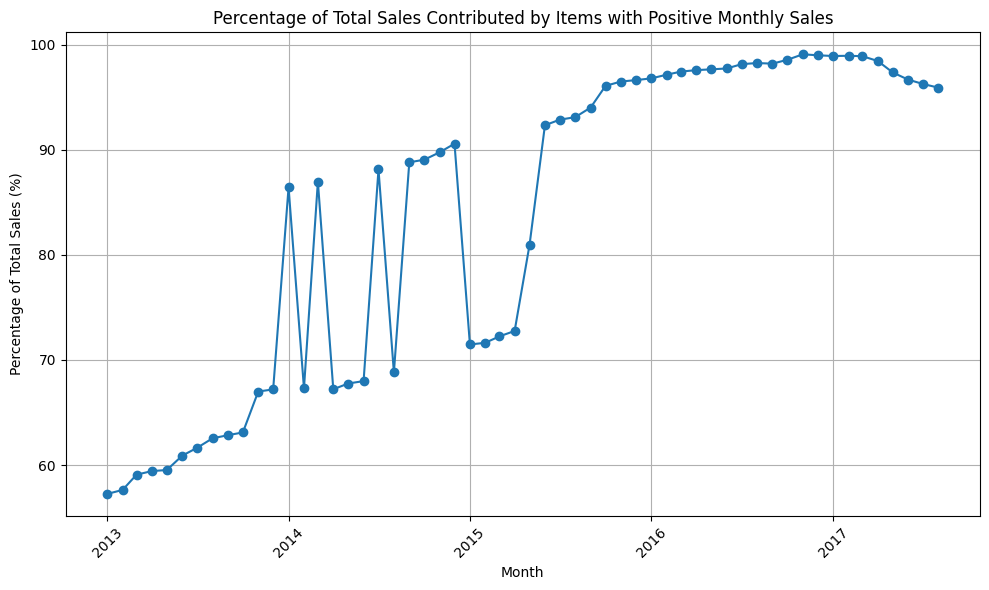

In [95]:


# Convert the 'month' column to a datetime format
results_df['month'] = results_df['month'].astype(str).str.replace('-', '') + '01'
results_df['month'] = pd.to_datetime(results_df['month'], format='%Y%m%d')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(results_df['month'], results_df['percentage_of_total_sales'], marker='o', linestyle='-')
plt.title('Percentage of Total Sales Contributed by Items with Positive Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Percentage of Total Sales (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


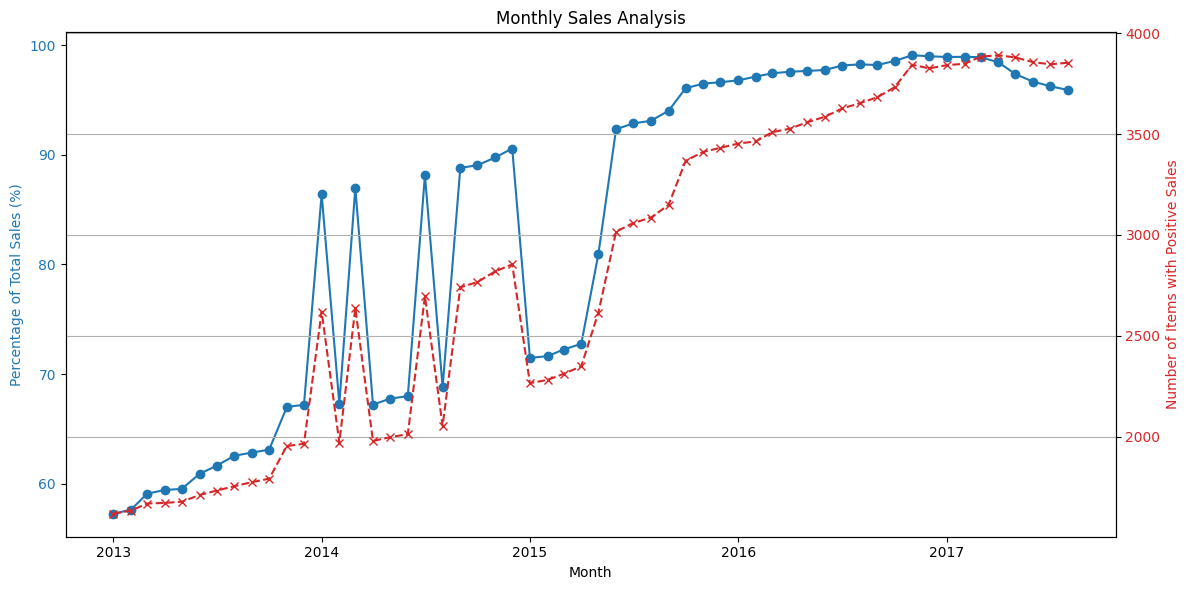

In [102]:




# Ensure the 'month' column is in a proper datetime format
results_df['month'] = pd.to_datetime(results_df['month'].astype(str))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot percentage of total sales
ax1.set_xlabel('Month')
ax1.set_ylabel('Percentage of Total Sales (%)', color='tab:blue')
ax1.plot(results_df['month'], results_df['percentage_of_total_sales'], marker='o', linestyle='-', color='tab:blue', label='Percentage of Total Sales')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot the number of items
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Items with Positive Sales', color='tab:red')
ax2.plot(results_df['month'], results_df['num_classes'], marker='x', linestyle='--', color='tab:red', label='Number of Items')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add titles and grid
plt.title('Monthly Sales Analysis')
fig.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

